75
(721, 6)
0.0339742273333 0.00599600744727
0.0178797296 0.0100702311591
0.0129927302667 0.00570288730203
1.04164643187 0.912260346723
0.00558942813333 0.00120058698574
0.00298299866667 0.000551641022657


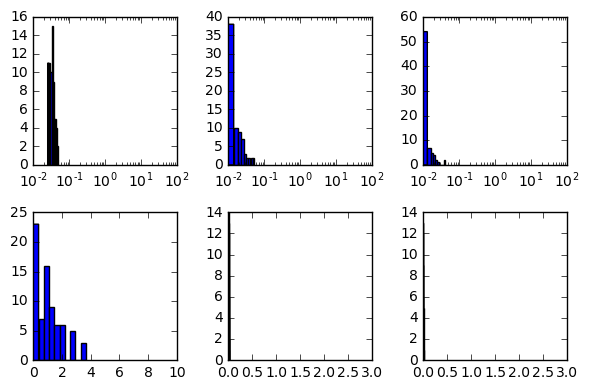

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
pd="/mnt/solexa/mel_yang/bronzeage/dadilik/"
myfile=open(pd+"dl_twopop_1000reps.main.log",'r')
mylines=myfile.readlines()
myfile.close()
for num,line in enumerate(mylines):
    if num%3!=0: continue
    x1=line.strip().split(':') 
    x2=mylines[num+1].strip().split(':') 
    mylst=[float(i) for i in x1[1][3:-1].split()]
    if len(mylst) < 6: continue
    if num==0: myary=np.array(mylst); llik=[]
    else: myary=np.vstack((myary,np.array(mylst)))
    llik.append(float(x2[1][1:]))

wantedllik=[(ind,i) for ind,i in enumerate(llik) if i > -17000]

ub = [100, 100, 100, 10, 3, 3]
lb = [1e-2, 1e-2, 1e-2, 0, 0, 0]
print len(wantedllik)
print myary.shape
fig=plt.figure()
for i in range(6):
    ax=fig.add_subplot(2,3,i+1)
    wanteddat=myary[[mytup[0] for mytup in wantedllik],i]
    if i in [0,1,2]: 
        ax.hist(wanteddat)
        ax.set_xscale('log')
    else: ax.hist(wanteddat)
    ax.set_xlim((lb[i],ub[i]))
    print np.mean(wanteddat), np.std(wanteddat)
    
    
plt.tight_layout()

In [7]:
3%3

0

In [2]:
%%writefile /mnt/solexa/mel_yang/bronzeage/dadilik/calcdadilik_twopop.py
##ivpp above mpi below
#%%writefile /home/melinda_yang/projects/bronzeage/calcdadilik_twopop.py

from dadi import Numerics , PhiManip , Integration , Spectrum, Misc, Inference

pd="/home/melinda_yang/projects/bronzeage/" #mpi
pd="/mnt/solexa/mel_yang/bronzeage/dadilik/" #ivpp
fh="ind_A_v13_TBH"
datdict=Misc.make_data_dict(pd+fh+".dadisnp")
popids=["Yoruba","French"]
ss=60
fs=Spectrum.from_data_dict(datdict,popids,[ss,ss])
data=fs
print data
ns=fs.sample_sizes
print 
def prior_onegrow_mig((nu1F, nu2B, nu2F, m, Tp, T), (n1,n2), pts):
    xx = yy = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    phi = Integration.one_pop(phi, xx, Tp, nu=nu1F)
    phi = PhiManip.phi_1D_to_2D(xx, phi)
    nu2_func = lambda t: nu2B*(nu2F/nu2B)**(t/T)
    phi = Integration.two_pops(phi, xx, T, nu1=nu1F, nu2=nu2_func, 
                                    m12=m, m21=m)
    sfs = Spectrum.from_phi(phi, (n1,n2), (xx,yy))
    return sfs

reps=1000
for i in range(reps):
    pts_l=[40,50,60]
    func=prior_onegrow_mig
    ##(nu1F, nu2B, nu2F, m, Tp, T)
    upper_bound = [100, 100, 100, 10, 3, 3]
    lower_bound = [1e-2, 1e-2, 1e-2, 0, 0, 0]
    p0 = [2,0.1,2,1,0.2,0.2]
    func_ex = Numerics.make_extrap_log_func(func)
    p0 = Misc.perturb_params(p0,fold=1,upper_bound=upper_bound,lower_bound=lower_bound)
    print('Beginning optimization ************************************************')
    popt = Inference.optimize_log(p0, data, func_ex, pts_l, 
                                       lower_bound=lower_bound,
                                       upper_bound=upper_bound,
                                       verbose=len(p0), maxiter=20)
    print('Finshed optimization **************************************************')
    print('Rep'+str(reps)+'Best-fit parameters: {0}'.format(popt))
    # Calculate the best-fit model AFS.
    model = func_ex(popt, ns, pts_l)
    # Likelihood of the data given the model AFS.
    ll_model = Inference.ll_multinom(model, data)
    print('Rep'+str(reps)+'Maximum log composite likelihood: {0}'.format(ll_model))
    # The optimal value of theta given the model.
    theta = Inference.optimal_sfs_scaling(model, data)
    print('Rep'+str(reps)+'Optimal value of theta: {0}'.format(theta))


Overwriting /mnt/solexa/mel_yang/bronzeage/dadilik/calcdadilik_twopop.py


In [27]:
from dadi import Numerics , PhiManip , Integration , Spectrum, Misc, Inference

pd="/home/melinda_yang/projects/bronzeage/" #mpi
pd="/mnt/solexa/mel_yang/bronzeage/dadilik/" #ivpp
fh="ind_A_v13_TBH"
datdict=Misc.make_data_dict(pd+fh+".dadisnp")
popids=["French","Yoruba"] 
##French=122,Han_HGDP=66,Yoruba=140
ss=10
for ss in [10,20,30,40,50,60]:
    fs=Spectrum.from_data_dict(datdict,popids,[ss,ss])
    ns=fs.sample_sizes
    print ss, fs.S()

10 293085.064611
20 317397.572048
30 327345.532243
40 332974.003468
50 336680.613222
60 339350.515063


In [28]:
Inference.optimize_log??

In [ ]:
%%writefile /home/melinda_yang/ivpp/bronzeage/calcdadilik.py
from dadi import Numerics , PhiManip , Integration , Spectrum, Misc, Inference

pd="/home/melinda_yang/ivpp/bronzeage/"
fh="ind_A_v13_TBH"
datdict=Misc.make_data_dict(pd+fh+".dadisnp")
popids=["Yoruba","French","Han_HGDP"]
popss=[5,5,5]
ss=5
fs=Spectrum.from_data_dict(datdict,popids,[ss,ss,ss])
data=fs
ns=fs.sample_sizes
print 
def OutOfAfrica ((nuAf,nuB,nuEu0,nuEu,nuAs0,nuAs,mAfB,mAfEu,mAfAs,mEuAs,TAf,TB,TEuAs),
                 (n1,n2,n3),pts):
    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    phi = Integration.one_pop(phi,xx,TAf,nu=nuAf)
    phi = PhiManip.phi_1D_to_2D(xx,phi)
    phi = Integration.two_pops(phi,xx,TB,nu1=nuAf,nu2=nuB,m12=mAfB,m21=mAfB)
    phi = PhiManip.phi_2D_to_3D_split_2 ( xx , phi )
    nuEu_func = lambda t : nuEu0 *( nuEu / nuEu0 )**( t / TEuAs )
    nuAs_func = lambda t : nuAs0 *( nuAs / nuAs0 )**( t / TEuAs )
    phi = Integration.three_pops(phi,xx,TEuAs,nu1 = nuAf,nu2=nuEu_func,nu3=nuAs_func,
                                 m12=mAfEu,m13=mAfAs,m21=mAfEu,m23=mEuAs,m31=mAfAs,m32=mEuAs)
    fs = Spectrum.from_phi(phi,(n1,n2,n3),(xx,xx,xx))
    return fs

pts_l=[40,50,60]
func=OutOfAfrica
##(nuAf,nuB,nuEu0,nuEu,nuAs0,nuAs,mAfB,mAfEu,mAfAs,mEuAs,TAf,TB,TEuAs)
upper_bound=[100,100,100,100,100,100,10,10,10,10,3,3,3]
lower_bound=[1e-2,1e-2,1e-2,1e-2,1e-2,1e-2,0,0,0,0,0,0,0]
p0=[2,2,2,2,2,2,1,1,1,1,1,1,1]
func_ex = Numerics.make_extrap_log_func(func)
p0 = Misc.perturb_params(p0,fold=1,upper_bound=upper_bound,lower_bound=lower_bound)
print('Beginning optimization ************************************************')
popt = Inference.optimize_log(p0, data, func_ex, pts_l, 
                                   lower_bound=lower_bound,
                                   upper_bound=upper_bound,
                                   verbose=len(p0), maxiter=3)
print('Finshed optimization **************************************************')
print('Best-fit parameters: {0}'.format(popt))
# Calculate the best-fit model AFS.
model = func_ex(popt, ns, pts_l)
# Likelihood of the data given the model AFS.
ll_model = Inference.ll_multinom(model, data)
print('Maximum log composite likelihood: {0}'.format(ll_model))
# The optimal value of theta given the model.
theta = Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))


In [16]:
from dadi import Numerics , PhiManip , Integration , Spectrum, Misc, Inference

pd="/home/melinda_yang/projects/bronzeage/"
fh="ind_A_v13_TBH"
datdict=Misc.make_data_dict(pd+fh+".dadisnp")
popids=["Yoruba","French","Han_HGDP"]

ss=5
fs=Spectrum.from_data_dict(datdict,popids,[122,66,140])
data=fs
print fs.sample_sizes

IOError: [Errno 2] No such file or directory: '/home/melinda_yang/projects/bronzeage/ind_A_v13_TBH.dadisnp'

In [18]:
##Make SNP file in dadi format
##| Human | Chimp | Allele1 | YRI | CEU | Allele2 | YRI | CEU |  Gene | Position |
import collections
import gzip
import numpy as np
import itertools

pd="/home/melinda_yang/ivpp/bronzeage/"
fh="ind_A_v13_TBH"

popns=["French","Han_HGDP","Yoruba"]

newfile=open(pd+fh+".dadisnp",'w')
header=["Ref","Chimp","Allele1"] + popns+ ["Allele2"] + popns+ ["rsID","Chr","Pos"]
newfile.write('\t'.join(header)+'\n')

myinds=collections.defaultdict(list)
indfile=open(pd+fh+".ind",'r')
for ind,line in enumerate(indfile):
    x=line.split()
    if x[2] in popns: myinds[x[2]].append(ind)
    if x[2] == "Chimp": ancind=ind
indfile.close()

snpfile=open(pd+fh+".snp",'r')
mysnpinfo=[line.split() for line in snpfile]
snpfile.close()

genofile=gzip.open(pd+fh+".geno.gz",'r')
num=0
for ind,line in enumerate(genofile):
    mygenos=[[int(line[popind]) for popind in myinds[myset]] for myset in popns]
    if 9 in list(itertools.chain(*mygenos)): continue
    allele1,allele2=tuple(snpinfo[4:])
    chimpgeno=line[ancind]
    if chimpgeno == '2': chimpallele="-%s-" % allele2
    elif chimpgeno == '0': chimpallele="-%s-" % allele1
    else: print 'chimpgeno',chimpgeno
    snpinfo = mysnpinfo[ind]
    #print snpinfo
    allele2sum=[sum(i) for i in mygenos]
    allele1sum=[str(2*len(myinds[myset])-allele2sum[ind1]) for ind1,myset in enumerate(popns)]
    allele2sum=[str(i) for i in allele2sum]
    ref="-%s-" % snpinfo[4]
    rsid,chrom,pos=tuple(snpinfo[0:2]+[snpinfo[3]])
    newformat=[ref,chimpallele,allele1]+allele1sum+[allele2]+allele2sum+[rsid,chrom,pos]
    newfile.write('\t'.join(newformat) + '\n')
    #print allele1sum, allele2sum
    if num == 100: break
    num += 1
#print myinds
#print ancind

newfile.close()


In [1]:
67787/3

22595